In [103]:
from __future__ import division

from collections import defaultdict
import pickle
import os
import sys

from matplotlib import pyplot as plt
import pygraphviz as pgv
import numpy as np
import pandas as pd

import seaborn as sns
sns.set_style('whitegrid')

from lentil import datatools

%matplotlib inline

In [104]:
import logging
logging.getLogger().setLevel(logging.DEBUG)

[Grockit Kaggle Comp](https://www.kaggle.com/c/WhatDoYouKnow)

In [105]:
def interaction_history_from_grockit_data_set(data):
    """
    Parse Grockit data set into an interaction history
    
    :param pd.DataFrame data: A dataframe of raw interactions
    :rtype: datatools.InteractionHistory
    :return: An interaction history object
    """
    
    data['round_started_at'] = pd.to_datetime(data['round_started_at'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
    data['answered_at'] = pd.to_datetime(data['answered_at'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
        
    # sort by timestamp
    data.sort_index(by='answered_at', inplace=True, axis=0)
    
    # compute response times
    data['duration'] = (data['answered_at'] - data['round_started_at']) / np.timedelta64(1, 's')
    
    # get relevant columns and rename them
    data = data[['user_id', 'correct', 'question_id', 'answered_at', 'duration']]
    data.columns = ['user_id', 'outcome', 'module_id', 'timestamp', 'duration']
    
    # only keep interactions with binary outcomes and positive response times
    data = data[((data['outcome']==1) | (data['outcome']==0)) & (data['duration'] > 0)]
    
    # cast outcomes from 0/1 to False/True
    data['outcome'] = data['outcome'].apply(lambda x: x == 1)
    
    student_timesteps = defaultdict(int)
    timesteps = [None] * len(data)
    for i, (_, ixn) in enumerate(data.iterrows()):
        student_timesteps[ixn['user_id']] += 1
        timesteps[i] = student_timesteps[ixn['user_id']]
    data['timestep'] = timesteps
    
    data['module_type'] = [datatools.AssessmentInteraction.MODULETYPE] * len(data)
    
    lesson_data = data.copy(deep=True)
    lesson_data['module_type'] = [datatools.LessonInteraction.MODULETYPE] * len(lesson_data)
    
    return datatools.InteractionHistory(
        pd.concat([data, lesson_data], axis=0),
        sort_by_timestep=True)

In [106]:
data_path = os.path.join('data', 'grockit', 'valid_training.csv')
data_path = '/home/zvonimir/PycharmProjects/lentil/data/grockit/valid_training.csv'
df = pd.read_csv(data_path, delimiter=',')

In [107]:
print '\n'.join(df.columns)

correct
outcome
user_id
question_id
question_type
group_name
track_name
subtrack_name
tag_string
round_started_at
answered_at
deactivated_at
answer_id
game_type
num_players
date_of_test
question_set_id


In [108]:
print "Number of interactions = %d" % len(df)
print "Number of unique students = %d" % len(df['user_id'].unique())
print "Number of unique modules = %d" % len(df['question_id'].unique())

Number of interactions = 4763362
Number of unique students = 179106
Number of unique modules = 6045


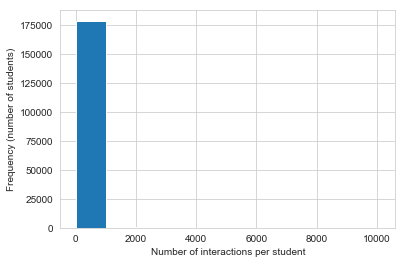

In [109]:
plt.xlabel('Number of interactions per student')
plt.ylabel('Frequency (number of students)')
plt.hist(df['user_id'].value_counts().values)
plt.show()

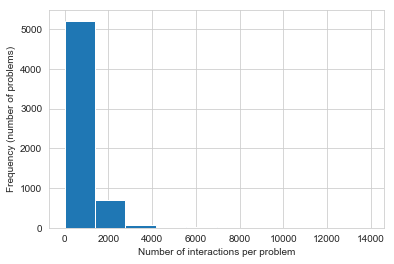

In [110]:
plt.xlabel('Number of interactions per problem')
plt.ylabel('Frequency (number of problems)')
plt.hist(df['question_id'].value_counts().values)
plt.show()

In [111]:
#unfiltered_history = interaction_history_from_grockit_data_set(df)
#


[Assistments](https://sites.google.com/site/assistmentsdata/home/assistment-2009-2010-data)

In [112]:
def interaction_history_from_assistments_data_set(
    data,
    duration_column='timestep',
    module_id_column='problem_id'):
    """
    Parse dataframe of assistments interactions into an interaction history

    :param pd.DataFrame assistments_data: A raw history from assistments
    :param str duration_column: Column to use as interaction duration
    :param str module_id_column: Column to use as module_id
    :rtype: datatools.InteractionHistory
    :return: An interaction history
    """
    # sort by order_id
    data.sort_index(by='order_id', inplace=True, axis=0)
    
    # get relevant columns and rename them
    data = data[['user_id', 'correct', duration_column, module_id_column]]
    data.columns = ['user_id', 'outcome', 'duration', 'module_id']

    # only keep interactions with binary outcomes and positive response times
    data = data[((data['outcome']==1) | (data['outcome']==0)) & (data['duration'] > 0)]
    
    # cast outcomes from int to bool
    data['outcome'] = data['outcome'].apply(lambda x: x == 1)

    # map response times from milliseconds to seconds
    data['duration'] = data['duration'].apply(lambda x: x / 1000)

    # existing interactions are all assessment interactions
    data['module_type'] = [datatools.AssessmentInteraction.MODULETYPE] * len(data)

    # add timesteps
    timesteps = [None] * len(data)
    student_timesteps = defaultdict(int)
    for i, (_, ixn) in enumerate(data.iterrows()):
        student_timesteps[ixn['user_id']] += 1
        timesteps[i] = student_timesteps[ixn['user_id']]
    data['timestep'] = timesteps

    # add artificial lesson interactions
    lesson_data = data.copy(deep=True)
    lesson_data['module_type'] = [datatools.LessonInteraction.MODULETYPE] * len(data)

    return datatools.InteractionHistory(
        pd.concat([data, lesson_data]),
        sort_by_timestep=True)

In [113]:
# data_path = os.path.join('data', 'assistments_2009_2010.csv')
# df = pd.read_csv(data_path, delimiter=',')
# history_path = os.path.join('data', 'assistments_2009_2010.pkl')
history_path = '/home/zvonimir/PycharmProjects/lentil/data/skill_builder_data.csv'
df=pd.read_csv(history_path)

In [114]:
print '\n'.join(df.columns)

order_id
assignment_id
user_id
assistment_id
problem_id
original
correct
attempt_count
ms_first_response
tutor_mode
answer_type
sequence_id
student_class_id
position
type
base_sequence_id
skill_id
skill_name
teacher_id
school_id
hint_count
hint_total
overlap_time
template_id
answer_id
answer_text
first_action
bottom_hint
opportunity
opportunity_original


In [115]:
print "Number of interactions = %d" % (len(df))
print "Number of unique students = %d" % (len(df['user_id'].unique()))
print "Number of unique modules = %d" % (len(df['problem_id'].unique()))

Number of interactions = 525534
Number of unique students = 4217
Number of unique modules = 26688


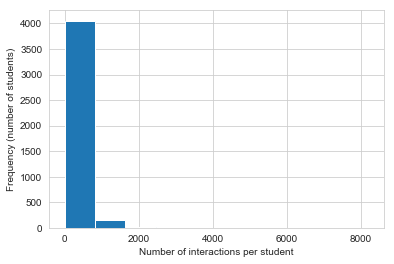

In [116]:
plt.xlabel('Number of interactions per student')
plt.ylabel('Frequency (number of students)')
plt.hist(df['user_id'].value_counts().values)
plt.show()

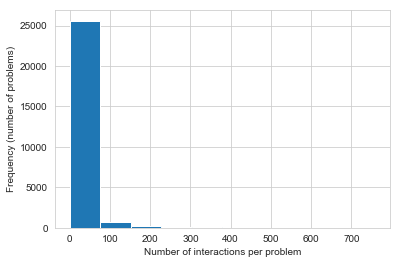

In [117]:
plt.xlabel('Number of interactions per problem')
plt.ylabel('Frequency (number of problems)')
plt.hist(df['problem_id'].value_counts().values)
plt.show()

In [118]:
unfiltered_history = interaction_history_from_assistments_data_set(
    df,
    module_id_column='problem_id',
    duration_column='ms_first_response')

/home/zvonimir/PycharmProjects/lentil/venv/lib/python2.7/site-packages/ipykernel_launcher.py:16: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  app.launch_new_instance()


Filter the interaction history

In [119]:
def filter_history(history, min_num_ixns=5, max_num_ixns=sys.maxint):
    """
    Filter history for students with histories of bounded length,
    and modules with enough interactions
    
    :param datatools.InteractionHistory history: An interaction history
    :param int min_num_ixns: Minimum number of timesteps in student history,
        and minimum number of interactions for module
    
    :param int max_num_ixns: Maximum number of timesteps in student history
    :rtype: datatools.InteractionHistory
    :return: A filtered interaction history
    """
    students = set(history.data['user_id'][(
                history.data['timestep'] > min_num_ixns) & (
                history.data['module_type']==datatools.AssessmentInteraction.MODULETYPE)])
    students -= set(history.data['user_id'][history.data['timestep'] >= max_num_ixns])
    
    modules = {module_id for module_id, group in history.data.groupby('module_id') if len(group) > min_num_ixns}

    return datatools.InteractionHistory(
        history.data[(history.data['user_id'].isin(students)) & (
                history.data['module_id'].isin(modules))],
        reindex_timesteps=True)

In [120]:
# apply the filter a couple of times, since removing student histories
# may cause certain modules to drop below the min_num_ixns threshold,
# and removing modules may cause student histories to drop below
# the min_num_ixns threshold
REPEATED_FILTER = 3 # number of times to repeat filtering
history = reduce(
    lambda acc, _: filter_history(acc, min_num_ixns=75, max_num_ixns=1000), 
    range(REPEATED_FILTER), unfiltered_history)

/home/zvonimir/PycharmProjects/lentil/lentil/datatools.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)


Explore basic stats about interaction history

In [121]:
num_interactions = len(df)
value_counts = df['module_type'].value_counts()
num_assessment_ixns = value_counts.get(datatools.AssessmentInteraction.MODULETYPE, 0)
num_lesson_ixns = value_counts.get(datatools.LessonInteraction.MODULETYPE, 0)

print "Number of interactions = %d" % (num_interactions)
print "Number of assessment interactions = %d" % (num_assessment_ixns)
print "Number of lesson interactions = %d" % (num_lesson_ixns)

num_students = history.num_students()

print "Number of unique students: %d" % (num_students)

num_assessments = history.num_assessments()

print "Number of unique assessments: %d" % (num_assessments)

num_lessons = history.num_lessons()

print "Number of unique lessons: %d" % (num_lessons)

value_counts = df['outcome'].value_counts()
num_passes = value_counts.get(True, 0)
num_fails = value_counts.get(False, 0)
pass_rate = num_passes / (num_passes + num_fails)

print "Overall pass rate: %f" % (pass_rate)

KeyError: 'module_type'

In [ ]:
d = []
for _, group in df.groupby('user_id'):
    d.extend(group['timestep'].value_counts().values)
d = np.array(d) - 1 # remove the lesson interaction at each timestep

plt.xlabel('Number of assessment interactions per timestep')
plt.ylabel('Frequency (number of timesteps)')
plt.hist(d)
plt.show()

In [ ]:
timestamps = pd.DatetimeIndex(df['timestamp'])

print "Beginning of data set = %s" % (min(timestamps))
print "End of data set = %s" % (max(timestamps))

hours = timestamps.hour
plt.xlabel('Hour of interaction')
plt.ylabel('Frequency (number of interactions)')
plt.hist(hours, bins=24)
plt.show()

# Monday=0, Sunday=6
days = timestamps.weekday
plt.xlabel('Day of interaction')
plt.ylabel('Frequency (number of interactions)')
plt.hist(days, bins=7)
plt.show()

In [ ]:
plt.xlabel('Timestep')
plt.ylabel('Frequency (number of interactions)')
plt.hist(df['timestep'].values)
plt.show()

In [ ]:
durations = np.array([x for x in df['duration'].values])

plt.xlabel('ln(response time, in seconds)')
plt.ylabel('Frequency (number of interactions)')
plt.hist(np.log(durations+1))
plt.show()

In [ ]:
counts = df['user_id'].value_counts().values
plt.xlabel('Number of interactions per student')
plt.ylabel('Frequency (number of students)')
plt.hist(counts)
plt.show()

In [ ]:
counts = df['module_id'][df['module_type'] == datatools.LessonInteraction.MODULETYPE].value_counts().values

plt.xlabel('Number of interactions per lesson module')
plt.ylabel('Frequency (number of lesson modules)')
plt.hist(counts)
plt.show()

In [ ]:
counts = df['module_id'][df['module_type'] == datatools.AssessmentInteraction.MODULETYPE].value_counts().values

plt.xlabel('Number of interactions per assessment module')
plt.ylabel('Frequency (number of assessment modules)')
plt.hist(counts)
plt.show()

In [ ]:
counts = df.groupby(['user_id', 'module_id']).size().values

plt.xlabel('Number of interactions per student per module')
plt.ylabel('Frequency (number of student-module pairs)')
plt.hist(counts)
plt.show()

In [ ]:
num_students_per_module = [len(group['user_id'].unique()) for _, group in df.groupby('module_id')]

plt.xlabel('Number of students per module')
plt.ylabel('Frequency (number of modules)')
plt.hist(num_students_per_module)
plt.show()

In [ ]:
grouped = df[df['module_type']==datatools.AssessmentInteraction.MODULETYPE].groupby('user_id')
num_assessments_per_student = [len(group['module_id']) for _, group in grouped]

plt.xlabel('Number of assessment modules per student')
plt.ylabel('Frequency (number of students)')
plt.hist(num_assessments_per_student)
plt.show()

In [ ]:
grouped = df[df['module_type']==datatools.LessonInteraction.MODULETYPE].groupby('user_id')
num_lessons_per_student = [len(group['module_id']) for _, group in grouped]

plt.xlabel('Number of lesson modules per student')
plt.ylabel('Frequency (number of students)')
plt.hist(num_lessons_per_student)
plt.show()

In [ ]:
def get_pass_rates(grouped):
    """
    Get pass rate for each group
    
    :param pd.GroupBy grouped: A grouped dataframe
    :rtype: dict[str, float]
    :return: A dictionary mapping group name to pass rate
    """
    pass_rates = {}
    for name, group in grouped:
        vc = group['outcome'].value_counts()
        if True not in vc:
            pass_rates[name] = 0
        else:
            pass_rates[name] = vc[True] / len(group)
    return pass_rates

In [ ]:
grouped = df[df['module_type']==datatools.AssessmentInteraction.MODULETYPE].groupby('user_id')

plt.xlabel('Student pass rate')
plt.ylabel('Frequency (number of students)')
plt.hist(get_pass_rates(grouped).values())
plt.show()

In [ ]:
grouped = df[df['module_type']==datatools.AssessmentInteraction.MODULETYPE].groupby('module_id')

plt.xlabel('Assessment pass rate')
plt.ylabel('Frequency (number of assessments)')
plt.hist(get_pass_rates(grouped).values())
plt.show()

In [ ]:
def make_flow_graph(interaction_logs):
    """
    Create a graphviz object for the graph of 
    module transitions across all student paths
    
    :param pd.DataFrame interaction_logs: An interaction history
    :rtype pgv.AGraph
    :return Graph of module transitions in student paths
    """
    G = pgv.AGraph(directed=True)

    for module_id in interaction_logs['module_id'].unique():
        G.add_node(module_id)

    E = defaultdict(set)
    grouped = interaction_logs.groupby('user_id')
    for user_id, group in grouped:
        module_ids_in_student_path = group['module_id']
        for source_node, target_node in zip(module_ids_in_student_path[:-1], module_ids_in_student_path[1:]):
            if source_node != target_node: # stationary
                E[(source_node, target_node)] |= {user_id}

    for (source_node, target_node), students_that_made_transition in E.iteritems():
        G.add_edge(
            source_node,
            target_node,
            weight=len(students_that_made_transition))

    return G

In [ ]:
G = make_flow_graph(df)

In [ ]:
flow_graph_path = os.path.join('data', 'assistments_flow_graph.dot')

In [ ]:
G.write(flow_graph_path)

In [ ]:
def make_conn_graph(interaction_logs):
    """
    Create a graphviz object for the bi-partite graph connecting students
    with the modules they've interacted with
    
    :param pd.DataFrame interaction_logs: An interaction history
    :rtype pgv.AGraph
    :return Bi-partite graph of student-module interactions
    """
    G = pgv.AGraph(directed=True)

    for module_id in interaction_logs['module_id'].unique():
        G.add_node(module_id, label='module')

    grouped = interaction_logs.groupby('user_id')
    for user_id, group in grouped:
        G.add_node(user_id, label='student')
        for module_id in set(group['module_id'].values):
            G.add_edge(user_id, module_id)

    return G

In [ ]:
G = make_conn_graph(df)

In [ ]:
conn_graph_path = os.path.join('data', 'assistments_conn_graph.dot')

In [ ]:
G.write(conn_graph_path)